In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

import transformers
import datasets

In [9]:
slice_transformer = transformers.SliceTransformer(offset=10)
resize_transformer = transformers.Resize3DTransformer(target_size=(512,512,10))
reshape_transformer = transformers.ReshapeTransformer(shape=(10, 512, 512))
tensor_transformer = transformers.TensorTransformer()


dataset = datasets.Tumors(transforms=[slice_transformer, resize_transformer])

In [12]:
x,m,y = dataset[0]
x = x - x*m*.3
print(x.shape)

(512, 512, 10)


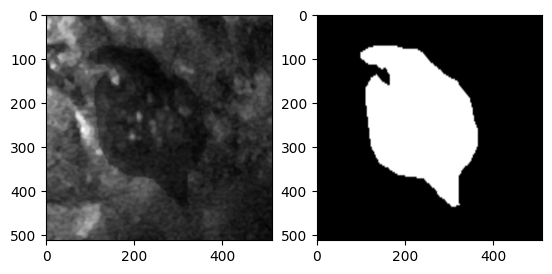

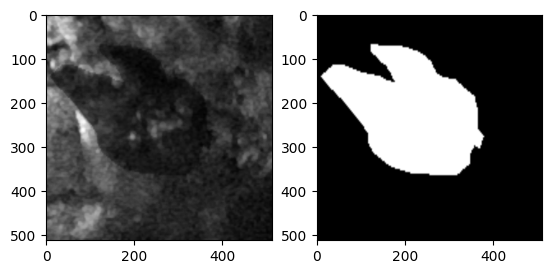

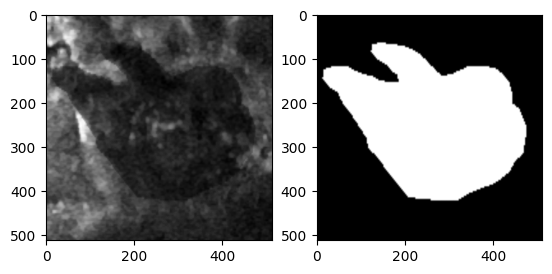

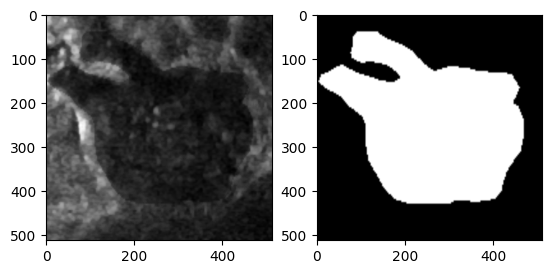

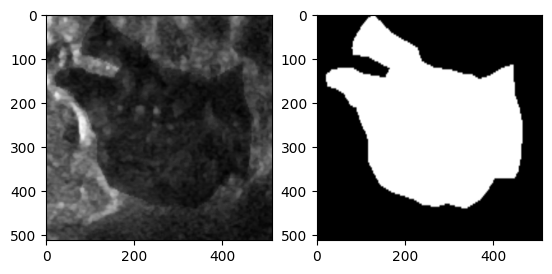

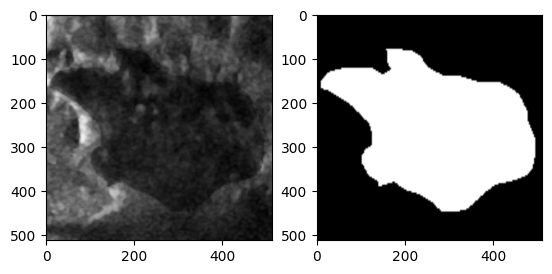

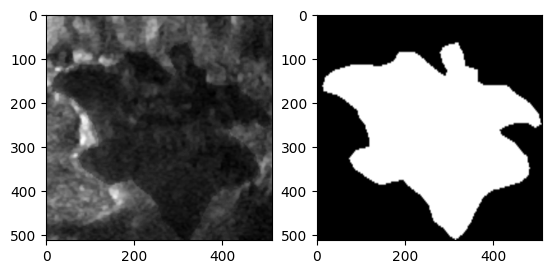

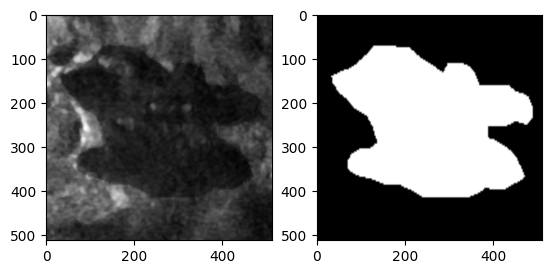

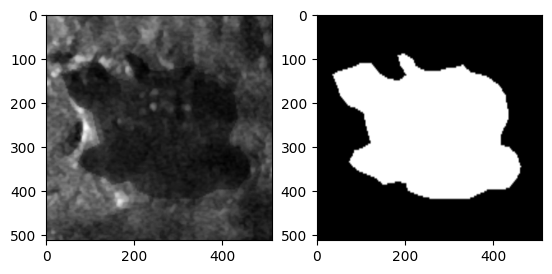

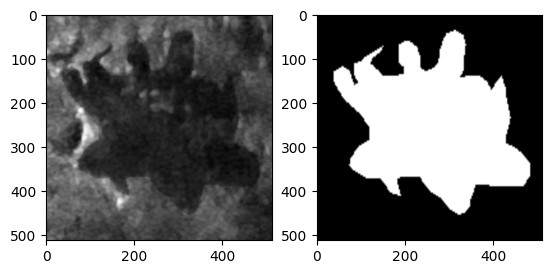

In [13]:
for i in range(10):
    
    sample_sli = x[:,:,i]
    sample_mask_sli = m[:,:,i]

    plt.subplot(1,2,1)
    plt.imshow(sample_sli, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(sample_mask_sli, cmap='gray')
    plt.show()

In [ ]:

# Define the 3D CNN model
class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool3d(2, 2)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16 * 5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)  # 2 classes: benign and malignant
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16 * 5)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = self.dropout(nn.functional.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:

# Convert numpy arrays to PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

# Create a dataset and data loader
train_dataset = CustomDataset(train_data_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Instantiate the model
model = CNN3D()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Remember to evaluate the model on a validation set and save it if needed